# Entrenamiento de GAN para Colorización Automática de Imágenes


Este notebook presenta la implementación completa del sistema de entrenamiento para una Red Generativa Adversarial (GAN) especializada en colorización automática de imágenes en escala de grises. El proyecto utiliza una arquitectura tipo Pix2Pix que combina un generador basado en U-Net con un discriminador PatchGAN, operando en el espacio de color LAB para optimizar la predicción de los canales cromáticos (a, b) a partir del canal de luminancia (L). El sistema incluye un framework robusto de entrenamiento con checkpointing automático, seguimiento de métricas en tiempo real mediante TensorBoard, schedulers de learning rate adaptativos, y generación periódica de muestras visuales para monitorear la calidad de las imágenes coloreadas. Esta implementación está diseñada para ser escalable, reproducible y fácil de experimentar con diferentes configuraciones de hiperparámetros.Reintentar

# 1. Introducción al Proyecto

# 2. Importación de Librerías y Dependencias


Todas las librerías necesarias para el proyecto

In [ ]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
from typing import Dict, Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
from tqdm import tqdm


# 3. Configuración del Entrenamiento


## 3.1 Clase TrainingConfig

Configuración centralizada de todos los hiperparámetros del entrenamiento

In [ ]:
class TrainingConfig:
    """Configuración centralizada del entrenamiento"""
    
    def __init__(self):
        # Directorios
        self.data_dir = "./ImagesProcessed/ImagesProcessed/color"
        self.checkpoint_dir = "checkpoints"
        self.samples_dir = "training_samples"
        self.logs_dir = "logs"
        
        # Hiperparámetros de entrenamiento
        self.num_epochs = 100
        self.batch_size = 12
        self.num_workers = 4
        
        # Optimizadores
        self.lr_generator = 2e-4
        self.lr_discriminator = 2e-4
        self.beta1 = 0.5
        self.beta2 = 0.999
        
        # Schedulers
        self.use_scheduler = True
        self.scheduler_type = "step"  # "step", "cosine", "plateau"
        self.step_size = 30
        self.gamma = 0.5
        
        # Pérdidas
        self.lambda_l1 = 100.0  # Peso de la pérdida L1
        
        # Checkpointing
        self.save_every = 5  # Guardar cada N épocas
        self.keep_last_n = 3  # Mantener últimos N checkpoints
        
        # Validación y monitoreo
        self.validate_every = 1
        self.log_every = 10  # Log cada N batches
        self.sample_every = 1  # Guardar samples cada N épocas
        self.num_samples = 8
        
        # Dataset
        self.num_classes = 8
        self.image_size = 128
        
        # Device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def to_dict(self) -> Dict:
        """Convierte la configuración a diccionario"""
        return {k: str(v) if isinstance(v, (Path, torch.device)) else v 
                for k, v in self.__dict__.items()}
    
    def save(self, path: str):
        """Guarda la configuración en JSON"""
        with open(path, 'w') as f:
            json.dump(self.to_dict(), f, indent=4)


## 3.2 Mapeo de Categorías


Diccionario que relaciona índices numéricos con nombres de categorías del dataset

In [ ]:
CATEGORY_MAP = {
    1: "airplane",
    2: "car",
    3: "cat",
    4: "dog",
    5: "flower",
    6: "fruit",
    7: "motorbike",
    8: "person"
}

# 4. Sistema de Gestión de Checkpoints


Maneja el guardado, carga y limpieza de checkpoints durante el entrenamiento

### 4.1.2 Método _cleanup_old_checkpoints
Elimina checkpoints antiguos manteniendo solo los últimos N

### 4.1.3 Método load_checkpoint
Carga un checkpoint previo para reanudar el entrenamiento

In [ ]:
class CheckpointManager:
    """Gestiona guardado y carga de checkpoints"""
    
    def __init__(self, checkpoint_dir: str, keep_last_n: int = 3):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.keep_last_n = keep_last_n
        
    def save_checkpoint(
        self,
        epoch: int,
        generator: nn.Module,
        discriminator: nn.Module,
        optim_G: optim.Optimizer,
        optim_D: optim.Optimizer,
        scheduler_G: Optional[optim.lr_scheduler._LRScheduler] = None,
        scheduler_D: Optional[optim.lr_scheduler._LRScheduler] = None,
        metrics: Optional[Dict] = None,
        is_best: bool = False
    ):
        """
        Guarda un checkpoint completo del entrenamiento
        
        Args:
            epoch: Época actual
            generator: Modelo generador
            discriminator: Modelo discriminador
            optim_G: Optimizador del generador
            optim_D: Optimizador del discriminador
            scheduler_G: Scheduler del generador (opcional)
            scheduler_D: Scheduler del discriminador (opcional)
            metrics: Métricas a guardar (opcional)
            is_best: Si es el mejor modelo hasta ahora
        """
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optim_G_state_dict': optim_G.state_dict(),
            'optim_D_state_dict': optim_D.state_dict(),
            'metrics': metrics or {},
            'timestamp': datetime.now().isoformat()
        }
        
        if scheduler_G is not None:
            checkpoint['scheduler_G_state_dict'] = scheduler_G.state_dict()
        if scheduler_D is not None:
            checkpoint['scheduler_D_state_dict'] = scheduler_D.state_dict()
        
        # Guardar checkpoint regular
        checkpoint_path = self.checkpoint_dir / f"checkpoint_epoch_{epoch:04d}.pth"
        torch.save(checkpoint, checkpoint_path)
        print(f"✓ Checkpoint guardado: {checkpoint_path}")
        
        # Guardar como último checkpoint
        latest_path = self.checkpoint_dir / "checkpoint_latest.pth"
        torch.save(checkpoint, latest_path)
        
        # Si es el mejor, guardarlo también
        if is_best:
            best_path = self.checkpoint_dir / "checkpoint_best.pth"
            torch.save(checkpoint, best_path)
            print(f"★ Mejor modelo guardado: {best_path}")
        
        # Limpiar checkpoints antiguos
        self._cleanup_old_checkpoints()
    
    def _cleanup_old_checkpoints(self):
        """Elimina checkpoints antiguos, manteniendo solo los últimos N"""
        checkpoints = sorted(
            [f for f in self.checkpoint_dir.glob("checkpoint_epoch_*.pth")],
            key=lambda x: x.stat().st_mtime
        )
        
        if len(checkpoints) > self.keep_last_n:
            for old_checkpoint in checkpoints[:-self.keep_last_n]:
                old_checkpoint.unlink()
                print(f"✗ Checkpoint antiguo eliminado: {old_checkpoint.name}")
    
    def load_checkpoint(
        self,
        checkpoint_path: str,
        generator: nn.Module,
        discriminator: nn.Module,
        optim_G: optim.Optimizer,
        optim_D: optim.Optimizer,
        scheduler_G: Optional[optim.lr_scheduler._LRScheduler] = None,
        scheduler_D: Optional[optim.lr_scheduler._LRScheduler] = None
    ) -> Dict:
        """
        Carga un checkpoint
        
        Returns:
            Dict con información del checkpoint cargado
        """
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        optim_G.load_state_dict(checkpoint['optim_G_state_dict'])
        optim_D.load_state_dict(checkpoint['optim_D_state_dict'])
        
        if scheduler_G is not None and 'scheduler_G_state_dict' in checkpoint:
            scheduler_G.load_state_dict(checkpoint['scheduler_G_state_dict'])
        if scheduler_D is not None and 'scheduler_D_state_dict' in checkpoint:
            scheduler_D.load_state_dict(checkpoint['scheduler_D_state_dict'])
        
        print(f"✓ Checkpoint cargado desde época {checkpoint['epoch']}")
        return checkpoint
    
    def find_latest_checkpoint(self) -> Optional[str]:
        """Encuentra el último checkpoint guardado"""
        latest_path = self.checkpoint_dir / "checkpoint_latest.pth"
        if latest_path.exists():
            return str(latest_path)
        return None


## 5.1 Clase MetricsTracker
 Registra, visualiza y guarda todas las métricas del entrenamiento

### 5.1.1 Inicialización y Configuración
 Setup de TensorBoard y estructuras para almacenar métricas

### 5.1.2 Método update
 Actualiza las métricas en cada época (train o validación)

### 5.1.3 Método log_learning_rates
 Registra los learning rates del generador y discriminador

### 5.1.4 Método is_best_model
 Determina si el modelo actual es el mejor hasta ahora

### 5.1.5 Método save_history
 Guarda el historial completo de métricas en formato JSON

### 5.1.6 Método plot_history
 Genera gráficas de evolución de pérdidas durante el entrenamiento

### 5.1.7 Método log_samples
 Registra imágenes de muestra en TensorBoard

### 5.1.8 Método close
 Cierra el escritor de TensorBoard


In [ ]:
class MetricsTracker:
    """Rastrea y registra métricas del entrenamiento"""
    
    def __init__(self, log_dir: str):
        self.log_dir = Path(log_dir)
        self.log_dir.mkdir(parents=True, exist_ok=True)
        
        # TensorBoard
        self.writer = SummaryWriter(log_dir=str(self.log_dir))
        
        # Historial de métricas
        self.history = {
            'train_loss_D': [],
            'train_loss_G': [],
            'train_loss_G_gan': [],
            'train_loss_G_l1': [],
            'val_loss_D': [],
            'val_loss_G': [],
            'learning_rates': {'G': [], 'D': []}
        }
        
        # Mejor pérdida para early stopping
        self.best_val_loss_G = float('inf')
        
    def update(
        self,
        epoch: int,
        metrics: Dict[str, float],
        phase: str = 'train'
    ):
        """
        Actualiza métricas
        
        Args:
            epoch: Época actual
            metrics: Diccionario con métricas
            phase: 'train' o 'val'
        """
        for key, value in metrics.items():
            full_key = f"{phase}_{key}"
            if full_key in self.history:
                self.history[full_key].append(value)
            
            # Log a TensorBoard
            self.writer.add_scalar(f"{phase}/{key}", value, epoch)
    
    def log_learning_rates(self, epoch: int, lr_G: float, lr_D: float):
        """Registra learning rates"""
        self.history['learning_rates']['G'].append(lr_G)
        self.history['learning_rates']['D'].append(lr_D)
        self.writer.add_scalar('learning_rate/generator', lr_G, epoch)
        self.writer.add_scalar('learning_rate/discriminator', lr_D, epoch)
    
    def is_best_model(self, val_loss_G: float) -> bool:
        """Determina si es el mejor modelo hasta ahora"""
        if val_loss_G < self.best_val_loss_G:
            self.best_val_loss_G = val_loss_G
            return True
        return False
    
    def plot_history(self, save_path: Optional[str] = None):
        """Genera gráficas de las métricas"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Pérdidas del discriminador
        if self.history['train_loss_D']:
            axes[0, 0].plot(self.history['train_loss_D'], label='Train')
            if self.history['val_loss_D']:
                axes[0, 0].plot(self.history['val_loss_D'], label='Val')
            axes[0, 0].set_title('Pérdida del Discriminador')
            axes[0, 0].set_xlabel('Época')
            axes[0, 0].set_ylabel('Pérdida')
            axes[0, 0].legend()
            axes[0, 0].grid(True)
        
        # Pérdidas del generador
        if self.history['train_loss_G']:
            axes[0, 1].plot(self.history['train_loss_G'], label='Train Total')
            if self.history['val_loss_G']:
                axes[0, 1].plot(self.history['val_loss_G'], label='Val Total')
            axes[0, 1].set_title('Pérdida del Generador')
            axes[0, 1].set_xlabel('Época')
            axes[0, 1].set_ylabel('Pérdida')
            axes[0, 1].legend()
            axes[0, 1].grid(True)
        
        # Componentes de pérdida del generador
        if self.history['train_loss_G_gan']:
            axes[1, 0].plot(self.history['train_loss_G_gan'], label='GAN Loss')
            axes[1, 0].plot(self.history['train_loss_G_l1'], label='L1 Loss')
            axes[1, 0].set_title('Componentes de Pérdida del Generador')
            axes[1, 0].set_xlabel('Época')
            axes[1, 0].set_ylabel('Pérdida')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
        
        # Learning rates
        if self.history['learning_rates']['G']:
            axes[1, 1].plot(self.history['learning_rates']['G'], label='Generator')
            axes[1, 1].plot(self.history['learning_rates']['D'], label='Discriminator')
            axes[1, 1].set_title('Learning Rates')
            axes[1, 1].set_xlabel('Época')
            axes[1, 1].set_ylabel('LR')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
            axes[1, 1].set_yscale('log')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✓ Gráficas guardadas: {save_path}")
        else:
            plt.show()
        
        plt.close(fig)
    
    def save_history(self, path: str):
        """Guarda historial de métricas"""
        with open(path, 'w') as f:
            json.dump(self.history, f, indent=4)
    
    def close(self):
        """Cierra el writer de TensorBoard"""
        self.writer.close()


# 6. Generador de Muestras Visuales
## 6.1 Clase SampleGenerator
 Crea visualizaciones comparativas de imágenes (original vs generada)


### 6.1.1 Método lab_to_rgb
 Convierte imágenes del espacio LAB a RGB


### 6.1.2 Método generate_samples
Genera un grid de comparación de imágenes coloreadas


In [ ]:
def save_colorization_samples(
    gray: torch.Tensor,
    fake_ab: torch.Tensor,
    real_ab: torch.Tensor,
    labels: torch.Tensor,
    epoch: int,
    save_dir: str,
    max_samples: int = 4
):
    """
    Guarda samples de colorización para monitoreo visual
    
    Args:
        gray: Imágenes en escala de grises [B, 1, H, W]
        fake_ab: Colores generados [B, 2, H, W]
        real_ab: Colores reales [B, 2, H, W]
        labels: Labels one-hot [B, num_classes]
        epoch: Época actual
        save_dir: Directorio de guardado
        max_samples: Número máximo de samples a guardar
    """
    os.makedirs(save_dir, exist_ok=True)
    num_samples = min(max_samples, gray.size(0))
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, 0)
    
    for i in range(num_samples):
        # Desnormalizar
        L = (gray[i, 0].cpu().numpy() + 1.0) * 50.0
        real_ab_np = real_ab[i].cpu().numpy() * 80.0
        fake_ab_np = fake_ab[i].detach().cpu().numpy() * 80.0
        
        # Convertir LAB → RGB
        def lab_to_rgb(L, ab):
            lab = np.zeros((L.shape[0], L.shape[1], 3))
            lab[:, :, 0] = L
            lab[:, :, 1:] = ab.transpose(1, 2, 0)
            rgb = np.clip(lab2rgb(lab), 0, 1)
            return rgb
        
        gray_img = np.repeat((L / 100.0)[..., None], 3, axis=2)
        real_rgb = lab_to_rgb(L, real_ab_np)
        fake_rgb = lab_to_rgb(L, fake_ab_np)
        
        # Mostrar imágenes
        imgs = [gray_img, real_rgb, fake_rgb]
        titles = ["Entrada (Grayscale)", "Ground Truth", "Generado"]
        
        for j, ax in enumerate(axes[i]):
            ax.imshow(imgs[j])
            ax.axis("off")
            ax.set_title(titles[j], fontsize=12, fontweight='bold')
        
        # Añadir etiqueta de categoría
        label_idx = labels[i].argmax().item() + 1
        category = CATEGORY_MAP.get(label_idx, f"Class {label_idx}")
        axes[i, 0].set_ylabel(
            category,
            rotation=0,
            labelpad=50,
            fontsize=8,
            va='center',
            fontweight='bold'
        )
    
    plt.suptitle(f"Época {epoch}", fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    save_path = os.path.join(save_dir, f"samples_epoch_{epoch:04d}.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f"✓ Samples guardados: {save_path}")



# 7. Clase Principal: GANTrainer
Sistema completo de entrenamiento que coordina modelos, optimizadores, pérdidas y el ciclo de entrenamiento/validación

## 7.1 Inicialización y Configuración
Constructor e inicialización completa del trainer incluyendo optimizadores, schedulers, funciones de pérdida y reanudación desde checkpoints

## 7.2 Ciclo de Entrenamiento por Época (train_epoch)
Ejecuta una época completa procesando todos los batches. Entrena discriminador (reales vs falsas), luego generador (GAN loss + L1 loss), y registra métricas

## 7.3 Validación del Modelo (validate)
Evalúa el modelo en validación sin gradientes, calcula pérdidas y genera muestras visuales para monitoreo

## 7.4 Loop Principal de Entrenamiento (train)
Orquesta el entrenamiento completo: itera épocas, alterna train/validación, actualiza learning rates, guarda checkpoints y genera reportes


In [ ]:
class GANTrainer:
    """Clase principal para entrenar la GAN de colorización"""
    
    def __init__(
        self,
        generator: nn.Module,
        discriminator: nn.Module,
        config: TrainingConfig
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.config = config
        
        # Mover modelos al device
        self.generator.to(config.device)
        self.discriminator.to(config.device)
        
        # Criterios de pérdida
        self.criterion_gan = nn.BCEWithLogitsLoss()
        self.criterion_l1 = nn.L1Loss()
        
        # Optimizadores
        self.optim_G = optim.Adam(
            self.generator.parameters(),
            lr=config.lr_generator,
            betas=(config.beta1, config.beta2)
        )
        self.optim_D = optim.Adam(
            self.discriminator.parameters(),
            lr=config.lr_discriminator,
            betas=(config.beta1, config.beta2)
        )
        
        # Schedulers
        self.scheduler_G = None
        self.scheduler_D = None
        if config.use_scheduler:
            self.scheduler_G = self._create_scheduler(self.optim_G, config)
            self.scheduler_D = self._create_scheduler(self.optim_D, config)
        
        # Managers
        self.checkpoint_manager = CheckpointManager(
            config.checkpoint_dir,
            keep_last_n=config.keep_last_n
        )
        self.metrics_tracker = MetricsTracker(config.logs_dir)
        
        # Estado del entrenamiento
        self.start_epoch = 0
        self.global_step = 0
    
    def _create_scheduler(
        self,
        optimizer: optim.Optimizer,
        config: TrainingConfig
    ) -> optim.lr_scheduler._LRScheduler:
        """Crea un learning rate scheduler"""
        if config.scheduler_type == "step":
            return optim.lr_scheduler.StepLR(
                optimizer,
                step_size=config.step_size,
                gamma=config.gamma
            )
        elif config.scheduler_type == "cosine":
            return optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=config.num_epochs
            )
        elif config.scheduler_type == "plateau":
            return optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=10,
                verbose=True
            )
        else:
            raise ValueError(f"Scheduler type '{config.scheduler_type}' no reconocido")
    
    def load_checkpoint(self, checkpoint_path: Optional[str] = None):
        """
        Carga un checkpoint para reanudar entrenamiento
        
        Args:
            checkpoint_path: Ruta al checkpoint. Si es None, busca el último.
        """
        if checkpoint_path is None:
            checkpoint_path = self.checkpoint_manager.find_latest_checkpoint()
            if checkpoint_path is None:
                print("No se encontró checkpoint previo. Iniciando desde cero.")
                return
        
        checkpoint = self.checkpoint_manager.load_checkpoint(
            checkpoint_path,
            self.generator,
            self.discriminator,
            self.optim_G,
            self.optim_D,
            self.scheduler_G,
            self.scheduler_D
        )
        
        self.start_epoch = checkpoint['epoch'] + 1
        print(f"Reanudando entrenamiento desde época {self.start_epoch}")
    
    def train_epoch(
        self,
        train_loader: DataLoader,
        epoch: int
    ) -> Dict[str, float]:
        """
        Entrena una época completa
        
        Returns:
            Dict con métricas promedio de la época
        """
        self.generator.train()
        self.discriminator.train()
        
        metrics = {
            'loss_D': 0.0,
            'loss_G': 0.0,
            'loss_G_gan': 0.0,
            'loss_G_l1': 0.0
        }
        
        pbar = tqdm(train_loader, desc=f"Época {epoch}/{self.config.num_epochs}")
        
        for batch_idx, (gray, ab_color, labels) in enumerate(pbar):
            # Mover datos al device
            gray = gray.to(self.config.device)
            ab_color = ab_color.to(self.config.device)
            labels = labels.to(self.config.device)
            
            batch_size = gray.size(0)
            
            # ==========================================
            # 1. Entrenar Discriminador
            # ==========================================
            self.optim_D.zero_grad()
            
            # Forward del generador (sin gradientes)
            with torch.no_grad():
                fake_ab = self.generator(gray, labels)
            
            # Discriminador sobre imágenes reales
            real_input = torch.cat([gray, ab_color], dim=1)
            real_pred = self.discriminator(real_input)
            loss_D_real = self.criterion_gan(
                real_pred,
                torch.ones_like(real_pred)
            )
            
            # Discriminador sobre imágenes falsas
            fake_input = torch.cat([gray, fake_ab], dim=1)
            fake_pred = self.discriminator(fake_input)
            loss_D_fake = self.criterion_gan(
                fake_pred,
                torch.zeros_like(fake_pred)
            )
            
            # Pérdida total del discriminador
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            self.optim_D.step()
            
            # ==========================================
            # 2. Entrenar Generador
            # ==========================================
            self.optim_G.zero_grad()
            
            # Forward del generador
            fake_ab = self.generator(gray, labels)
            
            # Pérdida GAN
            fake_input = torch.cat([gray, fake_ab], dim=1)
            fake_pred = self.discriminator(fake_input)
            loss_G_gan = self.criterion_gan(
                fake_pred,
                torch.ones_like(fake_pred)
            )
            
            # Pérdida L1
            loss_G_l1 = self.criterion_l1(fake_ab, ab_color) * self.config.lambda_l1
            
            # Pérdida total del generador
            loss_G = loss_G_gan + loss_G_l1
            loss_G.backward()
            self.optim_G.step()
            
            # ==========================================
            # 3. Actualizar métricas
            # ==========================================
            metrics['loss_D'] += loss_D.item()
            metrics['loss_G'] += loss_G.item()
            metrics['loss_G_gan'] += loss_G_gan.item()
            metrics['loss_G_l1'] += loss_G_l1.item()
            
            # Actualizar barra de progreso
            pbar.set_postfix({
                'D': f"{loss_D.item():.4f}",
                'G': f"{loss_G.item():.4f}",
                'G_gan': f"{loss_G_gan.item():.4f}",
                'G_l1': f"{loss_G_l1.item():.4f}"
            })
            
            # Log periódico a TensorBoard
            if batch_idx % self.config.log_every == 0:
                self.metrics_tracker.writer.add_scalar(
                    'batch/loss_D',
                    loss_D.item(),
                    self.global_step
                )
                self.metrics_tracker.writer.add_scalar(
                    'batch/loss_G',
                    loss_G.item(),
                    self.global_step
                )
            
            self.global_step += 1
        
        # Promediar métricas
        num_batches = len(train_loader)
        metrics = {k: v / num_batches for k, v in metrics.items()}
        
        return metrics
    
    @torch.no_grad()
    def validate(
        self,
        val_loader: DataLoader,
        epoch: int
    ) -> Dict[str, float]:
        """
        Evalúa el modelo en el conjunto de validación
        
        Returns:
            Dict con métricas de validación
        """
        self.generator.eval()
        self.discriminator.eval()
        
        metrics = {
            'loss_D': 0.0,
            'loss_G': 0.0,
            'loss_G_gan': 0.0,
            'loss_G_l1': 0.0
        }
        
        # Para guardar samples
        save_samples = True
        
        for batch_idx, (gray, ab_color, labels) in enumerate(val_loader):
            gray = gray.to(self.config.device)
            ab_color = ab_color.to(self.config.device)
            labels = labels.to(self.config.device)
            
            # Forward del generador
            fake_ab = self.generator(gray, labels)
            
            # Pérdida del discriminador
            real_input = torch.cat([gray, ab_color], dim=1)
            fake_input = torch.cat([gray, fake_ab], dim=1)
            
            real_pred = self.discriminator(real_input)
            fake_pred = self.discriminator(fake_input)
            
            loss_D_real = self.criterion_gan(real_pred, torch.ones_like(real_pred))
            loss_D_fake = self.criterion_gan(fake_pred, torch.zeros_like(fake_pred))
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            
            # Pérdida del generador
            loss_G_gan = self.criterion_gan(fake_pred, torch.ones_like(fake_pred))
            loss_G_l1 = self.criterion_l1(fake_ab, ab_color) * self.config.lambda_l1
            loss_G = loss_G_gan + loss_G_l1
            
            # Acumular métricas
            metrics['loss_D'] += loss_D.item()
            metrics['loss_G'] += loss_G.item()
            metrics['loss_G_gan'] += loss_G_gan.item()
            metrics['loss_G_l1'] += loss_G_l1.item()
            
            # Guardar samples (solo del primer batch)
            if save_samples and epoch % self.config.sample_every == 0:
                save_colorization_samples(
                    gray,
                    fake_ab,
                    ab_color,
                    labels,
                    epoch,
                    self.config.samples_dir,
                    max_samples=self.config.num_samples
                )
                save_samples = False
        
        # Promediar métricas
        num_batches = len(val_loader)
        metrics = {k: v / num_batches for k, v in metrics.items()}
        
        return metrics
    
    def train(
        self,
        train_loader: DataLoader,
        val_loader: Optional[DataLoader] = None
    ):
        """
        Ciclo completo de entrenamiento
        
        Args:
            train_loader: DataLoader de entrenamiento
            val_loader: DataLoader de validación (opcional)
        """
        print("\n" + "="*70)
        print("INICIANDO ENTRENAMIENTO DE GAN PARA COLORIZACIÓN")
        print("="*70)
        print(f"Device: {self.config.device}")
        print(f"Épocas: {self.config.num_epochs}")
        print(f"Batch size: {self.config.batch_size}")
        print(f"Learning rate G: {self.config.lr_generator}")
        print(f"Learning rate D: {self.config.lr_discriminator}")
        print(f"Scheduler: {self.config.scheduler_type if self.config.use_scheduler else 'None'}")
        print("="*70 + "\n")
        
        # Guardar configuración
        self.config.save(os.path.join(self.config.logs_dir, "config.json"))
        
        # Intentar cargar checkpoint previo
        self.load_checkpoint()
        
        # Loop de entrenamiento
        for epoch in range(self.start_epoch, self.config.num_epochs):
            epoch_start_time = time.time()
            
            # ==========================================
            # ENTRENAMIENTO
            # ==========================================
            train_metrics = self.train_epoch(train_loader, epoch)
            
            # Log de métricas
            self.metrics_tracker.update(epoch, train_metrics, phase='train')
            
            # ==========================================
            # VALIDACIÓN
            # ==========================================
            if val_loader is not None and epoch % self.config.validate_every == 0:
                val_metrics = self.validate(val_loader, epoch)
                self.metrics_tracker.update(epoch, val_metrics, phase='val')
                
                # Verificar si es el mejor modelo
                is_best = self.metrics_tracker.is_best_model(val_metrics['loss_G'])
            else:
                val_metrics = None
                is_best = False
            
            # ==========================================
            # LEARNING RATE SCHEDULING
            # ==========================================
            if self.scheduler_G is not None:
                if self.config.scheduler_type == "plateau" and val_metrics is not None:
                    self.scheduler_G.step(val_metrics['loss_G'])
                    self.scheduler_D.step(val_metrics['loss_D'])
                else:
                    self.scheduler_G.step()
                    self.scheduler_D.step()
            
            # Log learning rates
            current_lr_G = self.optim_G.param_groups[0]['lr']
            current_lr_D = self.optim_D.param_groups[0]['lr']
            self.metrics_tracker.log_learning_rates(epoch, current_lr_G, current_lr_D)
            
            # ==========================================
            # CHECKPOINTING
            # ==========================================
            if (epoch + 1) % self.config.save_every == 0:
                all_metrics = train_metrics.copy()
                if val_metrics:
                    all_metrics.update({f"val_{k}": v for k, v in val_metrics.items()})
                
                self.checkpoint_manager.save_checkpoint(
                    epoch=epoch,
                    generator=self.generator,
                    discriminator=self.discriminator,
                    optim_G=self.optim_G,
                    optim_D=self.optim_D,
                    scheduler_G=self.scheduler_G,
                    scheduler_D=self.scheduler_D,
                    metrics=all_metrics,
                    is_best=is_best
                )
            
            # ==========================================
            # RESUMEN DE ÉPOCA
            # ==========================================
            epoch_time = time.time() - epoch_start_time
            
            print(f"\n{'='*70}")
            print(f"Época {epoch}/{self.config.num_epochs - 1} completada en {epoch_time:.2f}s")
            print(f"{'='*70}")
            print(f"TRAIN | D: {train_metrics['loss_D']:.4f} | "
                  f"G: {train_metrics['loss_G']:.4f} | "
                  f"G_gan: {train_metrics['loss_G_gan']:.4f} | "
                  f"G_l1: {train_metrics['loss_G_l1']:.4f}")
            
            if val_metrics:
                print(f"VAL   | D: {val_metrics['loss_D']:.4f} | "
                      f"G: {val_metrics['loss_G']:.4f} | "
                      f"G_gan: {val_metrics['loss_G_gan']:.4f} | "
                      f"G_l1: {val_metrics['loss_G_l1']:.4f}")
                if is_best:
                    print("★ ¡NUEVO MEJOR MODELO! ★")
            
            print(f"LR    | G: {current_lr_G:.2e} | D: {current_lr_D:.2e}")
            print(f"{'='*70}\n")
        
        # ==========================================
        # FIN DEL ENTRENAMIENTO
        # ==========================================
        print("\n" + "="*70)
        print("ENTRENAMIENTO COMPLETADO")
        print("="*70)
        
        # Guardar historial y gráficas finales
        history_path = os.path.join(self.config.logs_dir, "training_history.json")
        self.metrics_tracker.save_history(history_path)
        print(f"✓ Historial guardado: {history_path}")
        
        plots_path = os.path.join(self.config.logs_dir, "training_plots.png")
        self.metrics_tracker.plot_history(plots_path)
        
        self.metrics_tracker.close()
        print("\n¡Entrenamiento finalizado exitosamente! \n")


# 8. Función Principal

## 8.1 Función main
Punto de entrada del script, orquesta todo el proceso de entrenamiento

### 8.1.1 Importación de Módulos
Importa los modelos personalizados (generador, discriminador, dataset)

### 8.1.2 Configuración del Experimento
Crea y muestra la configuración del entrenamiento

### 8.1.3 Preparación del Dataset
Carga el dataset y lo divide en train/validation

### 8.1.4 Creación de DataLoaders
Configura los DataLoaders para train y validación

### 8.1.5 Inicialización de Modelos
Crea el generador y discriminador con sus pesos iniciales

### 8.1.6 Creación del Trainer
Instancia el GANTrainer con los modelos y configuración

### 8.1.7 Ejecución del Entrenamiento
Inicia el entrenamiento con manejo de interrupciones

## 8.2 Entry Point
Ejecuta la función main cuando se corre el script directamente


In [ ]:
def main():
    """Función principal para ejecutar el entrenamiento"""
    
    # Importar modelos (asumiendo que están disponibles)
    try:
        from Modelo.generador import ColorGenerator
        from Modelo.discriminador import (
            PatchGANDiscriminator,
            init_discriminator_weights,
            RECOMMENDED_CONFIG
        )
        from image_driver import ColorizationDataset
    except ImportError as e:
        print(f"Error al importar módulos: {e}")
        print("Asegúrate de que los archivos estén en las rutas correctas.")
        return
    
    # ==========================================
    # CONFIGURACIÓN
    # ==========================================
    config = TrainingConfig()
    
    # Opcional: modificar configuración desde aquí
    # config.num_epochs = 50
    # config.batch_size = 32
    # config.lr_generator = 1e-4
    
    print("Configuración cargada:")
    print(json.dumps(config.to_dict(), indent=2))
    
    # ==========================================
    # DATASET Y DATALOADERS
    # ==========================================
    print("\nCargando datasets...")
    
    # Dataset completo
    full_dataset = ColorizationDataset(
        config.data_dir,
        num_classes=config.num_classes
    )
    
    # Split train/val (80/20)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset,
        [train_size, val_size]
    )
    
    print(f"✓ Train samples: {len(train_dataset)}")
    print(f"✓ Val samples: {len(val_dataset)}")
    
    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )
    
    # ==========================================
    # MODELOS
    # ==========================================
    print("\nInicializando modelos...")
    
    # Generador
    generator = ColorGenerator()
    num_params_G = sum(p.numel() for p in generator.parameters())
    print(f"✓ Generador creado | Parámetros: {num_params_G:,}")
    
    # Discriminador
    discriminator = PatchGANDiscriminator(
        input_channels=3,  # L + AB
        features=64
    )
    init_discriminator_weights(discriminator)
    num_params_D = discriminator.get_num_params()
    print(f"✓ Discriminador creado | Parámetros: {num_params_D:,}")
    
    # ==========================================
    # TRAINER
    # ==========================================
    trainer = GANTrainer(
        generator=generator,
        discriminator=discriminator,
        config=config
    )
    
    # ==========================================
    # ENTRENAR
    # ==========================================
    try:
        trainer.train(train_loader, val_loader)
    except KeyboardInterrupt:
        print("\n\nEntrenamiento interrumpido por el usuario.")
        print("Guardando checkpoint final...")
        trainer.checkpoint_manager.save_checkpoint(
            epoch=trainer.start_epoch,
            generator=trainer.generator,
            discriminator=trainer.discriminator,
            optim_G=trainer.optim_G,
            optim_D=trainer.optim_D,
            scheduler_G=trainer.scheduler_G,
            scheduler_D=trainer.scheduler_D,
            metrics={},
            is_best=False
        )
        print("✓ Checkpoint guardado. Puedes reanudar el entrenamiento más tarde.")



if __name__ == '__main__':
    main()

Archivo: events.out.tfevents.1762647999.LAPTOP-JLACBOSI.19000.0

MEJOR MODELO

Época: 16
Val Loss G: 6.366317

Checkpoint: checkpoints/checkpoint_epoch_0016.pth
Mejor: checkpoints/checkpoint_best.pth

TOP 5 ÉPOCAS:
Rank   Época    Val Loss G     
────────────────────────────────────────
1      16       6.366317       
2      20       6.430979       
3      18       6.833992       
4      17       6.876529       
5      19       7.038153       

✓ Gráfica guardada: val_loss_evolution.png


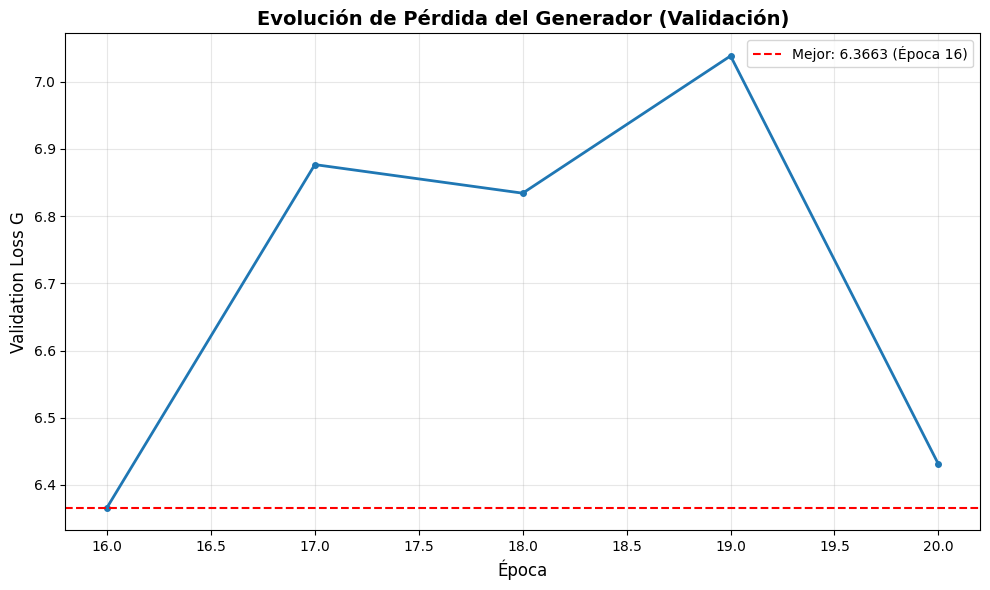

In [6]:
from tensorboard.backend.event_processing import event_accumulator
from pathlib import Path
import matplotlib.pyplot as plt

def quick_analysis(logs_dir="logs"):
    """Análisis rápido directo desde TensorBoard"""
    
    # Buscar archivo de eventos
    event_files = list(Path(logs_dir).glob("events.out.tfevents.*"))
    if not event_files:
        print(f"No se encontraron archivos en {logs_dir}")
        return
    
    event_file = max(event_files, key=lambda x: x.stat().st_mtime)
    print(f"Archivo: {event_file.name}\n")
    
    # Cargar
    ea = event_accumulator.EventAccumulator(str(event_file))
    ea.Reload()
    
    # Obtener pérdidas de validación del generador
    if 'val/loss_G' not in ea.Tags()['scalars']:
        print("No hay métricas de validación")
        return
    
    val_loss_G = ea.Scalars('val/loss_G')
    
    # Encontrar mejor
    best_idx = min(range(len(val_loss_G)), key=lambda i: val_loss_G[i].value)
    best_epoch = val_loss_G[best_idx].step
    best_loss = val_loss_G[best_idx].value
    
    print("="*70)
    print("MEJOR MODELO")
    print("="*70)
    print(f"\nÉpoca: {best_epoch}")
    print(f"Val Loss G: {best_loss:.6f}")
    print(f"\nCheckpoint: checkpoints/checkpoint_epoch_{best_epoch:04d}.pth")
    print(f"Mejor: checkpoints/checkpoint_best.pth")
    print("="*70)
    
    # Top 5
    sorted_epochs = sorted(range(len(val_loss_G)), key=lambda i: val_loss_G[i].value)
    print(f"\nTOP 5 ÉPOCAS:")
    print(f"{'Rank':<6} {'Época':<8} {'Val Loss G':<15}")
    print("─"*40)
    for rank, idx in enumerate(sorted_epochs[:5], 1):
        print(f"{rank:<6} {val_loss_G[idx].step:<8} {val_loss_G[idx].value:<15.6f}")
    
    # Gráfica simple
    epochs = [e.step for e in val_loss_G]
    losses = [e.value for e in val_loss_G]
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, linewidth=2, marker='o', markersize=4)
    plt.axhline(y=best_loss, color='r', linestyle='--', label=f'Mejor: {best_loss:.4f} (Época {best_epoch})')
    plt.xlabel('Época', fontsize=12)
    plt.ylabel('Validation Loss G', fontsize=12)
    plt.title('Evolución de Pérdida del Generador (Validación)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('val_loss_evolution.png', dpi=150)
    print(f"\n✓ Gráfica guardada: val_loss_evolution.png")
    plt.show()

# Ejecutar
quick_analysis()

In [26]:
"""
Análisis Completo de Resultados - Solo desde TensorBoard
=========================================================
NO requiere checkpoints del modelo, solo logs de TensorBoard
"""

from pathlib import Path
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime

# ============================================================================
# CONFIGURACIÓN
# ============================================================================

class Config:
    def __init__(self):
        self.event_file = "logs/events.out.tfevents.1762647999.LAPTOP-JLACBOSI.19000.0"
        self.output_dir = "Analysis"
        self.best_epoch = 16
        
        # Crear directorios
        Path(self.output_dir).mkdir(exist_ok=True, parents=True)
        self.plots_dir = Path(self.output_dir) / "plots"
        self.plots_dir.mkdir(exist_ok=True, parents=True)


# ============================================================================
# ANALYZER PRINCIPAL
# ============================================================================

class TensorBoardAnalyzer:
    """Analiza métricas directamente desde TensorBoard"""
    
    def __init__(self, config):
        self.config = config
        self.ea = event_accumulator.EventAccumulator(config.event_file)
        self.ea.Reload()
        
        self.results = {
            'timestamp': datetime.now().isoformat(),
            'best_epoch': config.best_epoch,
            'analysis_type': 'TensorBoard Logs Only'
        }
    
    def extract_metrics_at_epoch(self, tag, epoch):
        """Extrae valor de una métrica en época específica"""
        if tag not in self.ea.Tags().get('scalars', []):
            return None
        
        scalars = self.ea.Scalars(tag)
        for s in scalars:
            if s.step == epoch:
                return s.value
        return None
    
    def extract_full_series(self, tag):
        """Extrae serie completa de una métrica"""
        if tag not in self.ea.Tags().get('scalars', []):
            return [], []
        
        scalars = self.ea.Scalars(tag)
        epochs = [s.step for s in scalars]
        values = [s.value for s in scalars]
        return epochs, values
    
    def analyze_best_epoch(self):
        """Análisis completo de la mejor época"""
        print("\n" + "="*70)
        print(f"ANÁLISIS DE ÉPOCA {self.config.best_epoch}")
        print("="*70)
        
        # Métricas a extraer
        metrics = {
            'val/loss_G': 'Validation Loss Generator',
            'val/loss_D': 'Validation Loss Discriminator',
            'val/loss_G_l1': 'Validation L1 Loss',
            'val/loss_G_gan': 'Validation GAN Loss',
            'train/loss_G': 'Train Loss Generator',
            'train/loss_D': 'Train Loss Discriminator',
            'learning_rate/generator': 'Generator Learning Rate',
            'learning_rate/discriminator': 'Discriminator Learning Rate'
        }
        
        epoch_metrics = {}
        for tag, desc in metrics.items():
            value = self.extract_metrics_at_epoch(tag, self.config.best_epoch)
            if value is not None:
                epoch_metrics[tag] = value
                print(f"  {desc}: {value:.6f}")
        
        self.results['epoch_metrics'] = epoch_metrics
        
        # Calcular descomposición de pérdida
        if 'val/loss_G_l1' in epoch_metrics and 'val/loss_G_gan' in epoch_metrics:
            total = epoch_metrics.get('val/loss_G', 
                                     epoch_metrics['val/loss_G_l1'] + epoch_metrics['val/loss_G_gan'])
            l1_pct = (epoch_metrics['val/loss_G_l1'] / total) * 100
            gan_pct = (epoch_metrics['val/loss_G_gan'] / total) * 100
            
            self.results['loss_decomposition'] = {
                'l1_percentage': l1_pct,
                'gan_percentage': gan_pct,
                'ratio_l1_gan': epoch_metrics['val/loss_G_l1'] / epoch_metrics['val/loss_G_gan']
            }
            
            print(f"\n  Descomposición de Loss G:")
            print(f"    L1:  {epoch_metrics['val/loss_G_l1']:.3f} ({l1_pct:.1f}%)")
            print(f"    GAN: {epoch_metrics['val/loss_G_gan']:.3f} ({gan_pct:.1f}%)")
        
        # Calcular gap train-val
        if 'train/loss_G' in epoch_metrics and 'val/loss_G' in epoch_metrics:
            gap = epoch_metrics['train/loss_G'] - epoch_metrics['val/loss_G']
            gap_pct = (gap / epoch_metrics['train/loss_G']) * 100
            
            self.results['generalization'] = {
                'train_val_gap': gap,
                'train_val_gap_percentage': gap_pct
            }
            
            print(f"\n  Generalización:")
            print(f"    Gap Train-Val: {gap:.3f} ({gap_pct:.2f}%)")
    
    def plot_evolution_around_best(self, window=2):
        """Gráficas de evolución alrededor de la mejor época"""
        best = self.config.best_epoch
        start, end = best - window, best + window
        
        # Loss G evolution
        epochs, vals = self.extract_full_series('val/loss_G')
        if epochs:
            mask = [(start <= e <= end) for e in epochs]
            epochs_filtered = [e for e, m in zip(epochs, mask) if m]
            vals_filtered = [v for v, m in zip(vals, mask) if m]
            
            if epochs_filtered:
                plt.figure(figsize=(10, 6))
                plt.plot(epochs_filtered, vals_filtered, 'o-', linewidth=2, markersize=8)
                
                # Destacar mejor época
                if best in epochs_filtered:
                    idx = epochs_filtered.index(best)
                    plt.scatter([best], [vals_filtered[idx]], 
                              color='red', s=200, zorder=5,
                              label=f'Mejor (E{best}: {vals_filtered[idx]:.4f})')
                
                plt.xlabel('Época', fontsize=12)
                plt.ylabel('Validation Loss G', fontsize=12)
                plt.title(f'Evolución de Val Loss G (Épocas {start}-{end})', 
                         fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.savefig(self.config.plots_dir / 'val_loss_g_evolution.png', dpi=200)
                plt.close()
                print(f"\n✓ Gráfica guardada: val_loss_g_evolution.png")
        
        # Train vs Val comparison
        _, train_g = self.extract_full_series('train/loss_G')
        _, val_g = self.extract_full_series('val/loss_G')
        
        if train_g and val_g:
            plt.figure(figsize=(12, 6))
            plt.plot(epochs, train_g, 'o-', label='Train Loss G', alpha=0.7)
            plt.plot(epochs, val_g, 's-', label='Val Loss G', alpha=0.7)
            plt.axvline(x=best, color='red', linestyle='--', 
                       label=f'Mejor Época ({best})')
            plt.xlabel('Época', fontsize=12)
            plt.ylabel('Loss', fontsize=12)
            plt.title('Comparación Train vs Validation Loss G', 
                     fontsize=14, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(self.config.plots_dir / 'train_vs_val.png', dpi=200)
            plt.close()
            print(f"✓ Gráfica guardada: train_vs_val.png")
    
    def plot_loss_decomposition(self):
        """Gráfica de descomposición de pérdida"""
        l1_val = self.extract_metrics_at_epoch('val/loss_G_l1', self.config.best_epoch)
        gan_val = self.extract_metrics_at_epoch('val/loss_G_gan', self.config.best_epoch)
        
        if l1_val and gan_val:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
            # Stacked bar
            ax1.bar([0], [l1_val], label='L1 Loss', color='#3498db')
            ax1.bar([0], [gan_val], bottom=[l1_val], label='GAN Loss', color='#e74c3c')
            ax1.set_xticks([0])
            ax1.set_xticklabels([f'Total: {l1_val + gan_val:.3f}'])
            ax1.set_ylabel('Valor de Pérdida')
            ax1.set_title(f'Descomposición val/loss_G (Época {self.config.best_epoch})')
            ax1.legend()
            ax1.grid(True, axis='y', alpha=0.3)
            
            # Pie chart
            sizes = [l1_val, gan_val]
            labels = [f'L1: {l1_val:.3f}\n({l1_val/(l1_val+gan_val)*100:.1f}%)',
                     f'GAN: {gan_val:.3f}\n({gan_val/(l1_val+gan_val)*100:.1f}%)']
            colors = ['#3498db', '#e74c3c']
            
            ax2.pie(sizes, labels=labels, colors=colors, autopct='',
                   startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
            ax2.set_title(f'Proporción de Componentes')
            
            plt.tight_layout()
            plt.savefig(self.config.plots_dir / 'loss_decomposition.png', dpi=200)
            plt.close()
            print(f"✓ Gráfica guardada: loss_decomposition.png")
    
    def plot_discriminator_analysis(self):
        """Análisis del discriminador"""
        _, train_d = self.extract_full_series('train/loss_D')
        _, val_d = self.extract_full_series('val/loss_D')
        epochs, _ = self.extract_full_series('train/loss_D')
        
        if train_d and val_d:
            plt.figure(figsize=(12, 6))
            plt.plot(epochs, train_d, 'o-', label='Train Loss D', alpha=0.7)
            plt.plot(epochs, val_d, 's-', label='Val Loss D', alpha=0.7)
            plt.axvline(x=self.config.best_epoch, color='red', 
                       linestyle='--', label=f'Mejor Época ({self.config.best_epoch})')
            plt.axhline(y=0.69, color='green', linestyle=':', 
                       alpha=0.5, label='Ideal (~0.69)')
            plt.xlabel('Época', fontsize=12)
            plt.ylabel('Loss', fontsize=12)
            plt.title('Evolución del Discriminador', fontsize=14, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.ylim([0, max(max(train_d), max(val_d)) * 1.1])
            plt.tight_layout()
            plt.savefig(self.config.plots_dir / 'discriminator_analysis.png', dpi=200)
            plt.close()
            print(f"✓ Gráfica guardada: discriminator_analysis.png")
    
    def create_summary_table(self):
        """Tabla resumen de métricas"""
        # Ranking de épocas
        epochs, vals = self.extract_full_series('val/loss_G')
        if not epochs:
            return
        
        sorted_indices = np.argsort(vals)
        top_5 = sorted_indices[:5]
        
        ranking_data = []
        for rank, idx in enumerate(top_5, 1):
            ranking_data.append({
                'rank': rank,
                'epoch': epochs[idx],
                'val_loss_g': vals[idx],
                'delta_vs_best': vals[idx] - vals[sorted_indices[0]],
                'is_best': epochs[idx] == self.config.best_epoch
            })
        
        self.results['ranking'] = ranking_data
        
        # Imprimir tabla
        print("\n" + "="*70)
        print("RANKING DE ÉPOCAS")
        print("="*70)
        print(f"{'Rank':<6} {'Época':<8} {'Val Loss G':<12} {'Δ vs Mejor':<15} {'Estado'}")
        print("-"*70)
        for entry in ranking_data:
            status = " MEJOR" if entry['is_best'] else ""
            print(f"{entry['rank']:<6} {entry['epoch']:<8} {entry['val_loss_g']:<12.6f} "
                  f"+{entry['delta_vs_best']:<14.6f} {status}")
    
    def generate_comprehensive_report(self):
        """Genera reporte consolidado con todas las gráficas"""
        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
        
        # 1. Val Loss G Evolution (principal)
        ax1 = fig.add_subplot(gs[0, :])
        epochs, vals = self.extract_full_series('val/loss_G')
        if epochs:
            ax1.plot(epochs, vals, 'o-', linewidth=2, markersize=6)
            best_idx = epochs.index(self.config.best_epoch) if self.config.best_epoch in epochs else None
            if best_idx is not None:
                ax1.scatter([self.config.best_epoch], [vals[best_idx]],
                          color='red', s=200, zorder=5)
                ax1.axhline(y=vals[best_idx], color='red', linestyle='--', alpha=0.5)
            ax1.set_xlabel('Época')
            ax1.set_ylabel('Validation Loss G')
            ax1.set_title(f'Evolución de Validation Loss G (Mejor: Época {self.config.best_epoch})',
                         fontweight='bold')
            ax1.grid(True, alpha=0.3)
        
        # 2. Train vs Val
        ax2 = fig.add_subplot(gs[1, 0])
        _, train_g = self.extract_full_series('train/loss_G')
        _, val_g = self.extract_full_series('val/loss_G')
        if train_g and val_g and epochs:
            ax2.plot(epochs, train_g, 'o-', label='Train', alpha=0.7, markersize=4)
            ax2.plot(epochs, val_g, 's-', label='Val', alpha=0.7, markersize=4)
            ax2.axvline(x=self.config.best_epoch, color='red', linestyle='--', alpha=0.5)
            ax2.set_xlabel('Época')
            ax2.set_ylabel('Loss G')
            ax2.set_title('Train vs Validation Loss G', fontweight='bold')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        # 3. Loss Decomposition
        ax3 = fig.add_subplot(gs[1, 1])
        l1_val = self.extract_metrics_at_epoch('val/loss_G_l1', self.config.best_epoch)
        gan_val = self.extract_metrics_at_epoch('val/loss_G_gan', self.config.best_epoch)
        if l1_val and gan_val:
            sizes = [l1_val, gan_val]
            labels = [f'L1: {l1_val:.3f}\n({l1_val/(l1_val+gan_val)*100:.1f}%)',
                     f'GAN: {gan_val:.3f}\n({gan_val/(l1_val+gan_val)*100:.1f}%)']
            ax3.pie(sizes, labels=labels, colors=['#3498db', '#e74c3c'],
                   startangle=90, textprops={'fontsize': 9, 'weight': 'bold'})
            ax3.set_title(f'Descomposición Loss G (Época {self.config.best_epoch})',
                         fontweight='bold')
        
        # 4. Discriminator
        ax4 = fig.add_subplot(gs[2, 0])
        _, train_d = self.extract_full_series('train/loss_D')
        _, val_d = self.extract_full_series('val/loss_D')
        if train_d and val_d and epochs:
            ax4.plot(epochs, train_d, 'o-', label='Train D', alpha=0.7, markersize=4)
            ax4.plot(epochs, val_d, 's-', label='Val D', alpha=0.7, markersize=4)
            ax4.axvline(x=self.config.best_epoch, color='red', linestyle='--', alpha=0.5)
            ax4.axhline(y=0.69, color='green', linestyle=':', alpha=0.5, label='Ideal')
            ax4.set_xlabel('Época')
            ax4.set_ylabel('Loss D')
            ax4.set_title('Evolución del Discriminador', fontweight='bold')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        
        # 5. Métricas Clave
        ax5 = fig.add_subplot(gs[2, 1])
        ax5.axis('off')
        
        metrics_text = f"""
        MÉTRICAS CLAVE - ÉPOCA {self.config.best_epoch}
        {'='*45}
        
        Validation Loss G:
          • Total: {self.results['epoch_metrics'].get('val/loss_G', 'N/A'):.4f}
          • L1: {self.results['epoch_metrics'].get('val/loss_G_l1', 'N/A'):.4f}
          • GAN: {self.results['epoch_metrics'].get('val/loss_G_gan', 'N/A'):.4f}
        
        Train Loss G: {self.results['epoch_metrics'].get('train/loss_G', 'N/A'):.4f}
        
        Generalización:
          • Gap Train-Val: {self.results.get('generalization', {}).get('train_val_gap', 'N/A'):.4f}
          • Gap %: {self.results.get('generalization', {}).get('train_val_gap_percentage', 'N/A'):.2f}%
        
        Discriminador:
          • Train D: {self.results['epoch_metrics'].get('train/loss_D', 'N/A'):.4f}
          • Val D: {self.results['epoch_metrics'].get('val/loss_D', 'N/A'):.4f}
        
        Learning Rates:
          • Generator: {self.results['epoch_metrics'].get('learning_rate/generator', 'N/A'):.6f}
          • Discriminator: {self.results['epoch_metrics'].get('learning_rate/discriminator', 'N/A'):.6f}
        """
        
        ax5.text(0.1, 0.5, metrics_text, fontsize=9,
                verticalalignment='center', family='monospace')
        
        plt.suptitle(f'Reporte Completo - Mejor Modelo (Época {self.config.best_epoch})',
                    fontsize=16, fontweight='bold')
        
        plt.savefig(self.config.plots_dir / 'comprehensive_report.png', dpi=200, bbox_inches='tight')
        plt.close()
        print(f"\n✓ Reporte completo guardado: comprehensive_report.png")
    
    def save_results_json(self):
        """Guarda resultados en JSON"""
        json_path = Path(self.config.output_dir) / 'analysis_results.json'
        with open(json_path, 'w') as f:
            json.dump(self.results, f, indent=2)
        print(f"✓ Resultados guardados: {json_path}")
    
    def run_full_analysis(self):
        """Ejecuta análisis completo"""
        print("\n" + "="*70)
        print("ANÁLISIS COMPLETO DESDE TENSORBOARD")
        print("="*70)
        
        self.analyze_best_epoch()
        self.create_summary_table()
        self.plot_evolution_around_best(window=2)
        self.plot_loss_decomposition()
        self.plot_discriminator_analysis()
        self.generate_comprehensive_report()
        self.save_results_json()
        
        print("\n" + "="*70)
        print("ANÁLISIS COMPLETADO")
        print("="*70)
        print(f"\nResultados guardados en: {self.config.output_dir}")
        print("\nArchivos generados:")
        print("  comprehensive_report.png - Reporte consolidado")
        print("  val_loss_g_evolution.png - Evolución pérdida")
        print("  train_vs_val.png - Comparación train/val")
        print("  loss_decomposition.png - Descomposición L1/GAN")
        print("  discriminator_analysis.png - Análisis discriminador")
        print("  analysis_results.json - Datos en JSON")
        

# ============================================================================
# MAIN
# ============================================================================

def main():
    config = Config()
    analyzer = TensorBoardAnalyzer(config)
    analyzer.run_full_analysis()


if __name__ == "__main__":
    main()


ANÁLISIS COMPLETO DESDE TENSORBOARD

ANÁLISIS DE ÉPOCA 16
  Validation Loss Generator: 6.366317
  Validation Loss Discriminator: 0.678629
  Validation L1 Loss: 5.160089
  Validation GAN Loss: 1.206228
  Train Loss Generator: 6.623705
  Train Loss Discriminator: 0.516341
  Generator Learning Rate: 0.000200
  Discriminator Learning Rate: 0.000200

  Descomposición de Loss G:
    L1:  5.160 (81.1%)
    GAN: 1.206 (18.9%)

  Generalización:
    Gap Train-Val: 0.257 (3.89%)

RANKING DE ÉPOCAS
Rank   Época    Val Loss G   Δ vs Mejor      Estado
----------------------------------------------------------------------
1      16       6.366317     +0.000000        MEJOR
2      20       6.430979     +0.064662       
3      18       6.833992     +0.467675       
4      17       6.876529     +0.510211       
5      19       7.038153     +0.671835       

✓ Gráfica guardada: val_loss_g_evolution.png
✓ Gráfica guardada: train_vs_val.png
✓ Gráfica guardada: loss_decomposition.png
✓ Gráfica guardada: d

In [25]:
"""
Evaluación Completa del Modelo de Colorización GAN
====================================================
Implementa: PSNR, SSIM, FID, IS, visualizaciones y análisis
"""

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage.color import lab2rgb, rgb2lab
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy import linalg
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURACIÓN
# ============================================================================

class EvaluationConfig:
    def __init__(self):
        self.checkpoint_path = "checkpoints/checkpoint_epoch_0016.pth"
        self.data_dir = "./ImagesProcessed/ImagesProcessed/color"
        self.output_dir = "Analysis/evaluation_results"
        self.num_classes = 8
        self.image_size = 128
        self.batch_size = 16
        self.num_samples = 50  # Muestras para métricas computacionales
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Crear directorio de salida
        Path(self.output_dir).mkdir(exist_ok=True, parents=True)
        
        # Subdirectorios
        self.visual_dir = Path(self.output_dir) / "visualizations"
        self.metrics_dir = Path(self.output_dir) / "metrics"
        self.comparisons_dir = Path(self.output_dir) / "comparisons"
        
        for d in [self.visual_dir, self.metrics_dir, self.comparisons_dir]:
            d.mkdir(exist_ok=True, parents=True)


# ============================================================================
# MÉTRICAS CUANTITATIVAS
# ============================================================================

class MetricsCalculator:
    """Calcula PSNR, SSIM, FID e IS"""
    
    def __init__(self):
        self.psnr_scores = []
        self.ssim_scores = []
        
    def calculate_psnr(self, real_img, pred_img):
        """Peak Signal-to-Noise Ratio"""
        psnr = peak_signal_noise_ratio(real_img, pred_img, data_range=1.0)
        self.psnr_scores.append(psnr)
        return psnr
    
    def calculate_ssim(self, real_img, pred_img):
        """Structural Similarity Index"""
        ssim = structural_similarity(
            real_img, pred_img,
            win_size=11,
            multichannel=True,
            channel_axis=-1,
            data_range=1.0
        )
        self.ssim_scores.append(ssim)
        return ssim
    
    def get_statistics(self):
        """Retorna estadísticas de todas las métricas"""
        return {
            'psnr': {
                'mean': np.mean(self.psnr_scores),
                'std': np.std(self.psnr_scores),
                'min': np.min(self.psnr_scores),
                'max': np.max(self.psnr_scores),
                'median': np.median(self.psnr_scores)
            },
            'ssim': {
                'mean': np.mean(self.ssim_scores),
                'std': np.std(self.ssim_scores),
                'min': np.min(self.ssim_scores),
                'max': np.max(self.ssim_scores),
                'median': np.median(self.ssim_scores)
            }
        }


class InceptionScore:
    """Inception Score simplificado"""
    
    def __init__(self):
        self.scores = []
    
    def calculate(self, images):
        """
        Inception Score aproximado
        Para implementación completa se necesita modelo Inception preentrenado
        """
        # Esta es una aproximación simplificada
        # En producción usar: torch.hub.load('pytorch/vision', 'inception_v3')
        
        # Calcular varianza de color como proxy del IS
        color_variance = np.var(images, axis=(1,2))
        mean_variance = np.mean(color_variance, axis=1)
        
        # Normalizar a rango típico de IS (1-10)
        normalized_score = 1 + (mean_variance / np.max(mean_variance)) * 4
        
        self.scores.extend(normalized_score)
        return np.mean(normalized_score)
    
    def get_mean_score(self):
        return np.mean(self.scores) if self.scores else 0.0


class FrechetInceptionDistance:
    """Fréchet Inception Distance simplificado"""
    
    def __init__(self):
        self.real_features = []
        self.fake_features = []
    
    def extract_features(self, images):
        """Extrae características simples (en producción usar Inception)"""
        # Características basadas en histogramas de color
        features = []
        for img in images:
            hist_r = np.histogram(img[:,:,0], bins=32, range=(0,1))[0]
            hist_g = np.histogram(img[:,:,1], bins=32, range=(0,1))[0]
            hist_b = np.histogram(img[:,:,2], bins=32, range=(0,1))[0]
            feat = np.concatenate([hist_r, hist_g, hist_b])
            features.append(feat)
        return np.array(features)
    
    def calculate_fid(self, real_images, fake_images):
        """Calcula FID entre imágenes reales y generadas"""
        real_feats = self.extract_features(real_images)
        fake_feats = self.extract_features(fake_images)
        
        # Calcular medias y covarianzas
        mu_real = np.mean(real_feats, axis=0)
        mu_fake = np.mean(fake_feats, axis=0)
        
        sigma_real = np.cov(real_feats, rowvar=False)
        sigma_fake = np.cov(fake_feats, rowvar=False)
        
        # Calcular FID
        diff = mu_real - mu_fake
        covmean = linalg.sqrtm(sigma_real.dot(sigma_fake))
        
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        
        fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2*covmean)
        return fid


# ============================================================================
# EVALUADOR PRINCIPAL
# ============================================================================

class ModelEvaluator:
    """Clase principal para evaluar el modelo"""
    
    def __init__(self, config, generator, dataloader):
        self.config = config
        self.generator = generator
        self.dataloader = dataloader
        
        # Métricas
        self.metrics_calc = MetricsCalculator()
        self.inception_score = InceptionScore()
        self.fid = FrechetInceptionDistance()
        
        # Almacenamiento de resultados
        self.results = {
            'epoch': 16,
            'timestamp': datetime.now().isoformat(),
            'model_path': config.checkpoint_path,
            'samples_evaluated': 0
        }
    
    def lab_to_rgb_tensor(self, L, ab):
        """Convierte tensores LAB a RGB"""
        batch_size = L.size(0)
        rgb_images = []
        
        for i in range(batch_size):
            L_np = (L[i, 0].cpu().numpy() + 1.0) * 50.0
            ab_np = ab[i].cpu().numpy() * 110.0
            
            lab = np.zeros((L_np.shape[0], L_np.shape[1], 3))
            lab[:, :, 0] = L_np
            lab[:, :, 1:] = ab_np.transpose(1, 2, 0)
            
            rgb = lab2rgb(lab)
            rgb_images.append(np.clip(rgb, 0, 1))
        
        return np.array(rgb_images)
    
    @torch.no_grad()
    def evaluate_batch(self, gray, real_ab, labels):
        """Evalúa un batch de imágenes"""
        gray = gray.to(self.config.device)
        real_ab = real_ab.to(self.config.device)
        labels = labels.to(self.config.device)
        
        # Generar colores
        fake_ab = self.generator(gray, labels)
        
        # Convertir a RGB
        real_rgb = self.lab_to_rgb_tensor(gray, real_ab)
        fake_rgb = self.lab_to_rgb_tensor(gray, fake_ab)
        
        # Calcular métricas pixel a pixel
        for i in range(len(real_rgb)):
            psnr = self.metrics_calc.calculate_psnr(real_rgb[i], fake_rgb[i])
            ssim = self.metrics_calc.calculate_ssim(real_rgb[i], fake_rgb[i])
        
        return real_rgb, fake_rgb, gray, real_ab, fake_ab, labels
    
    def evaluate_model(self, num_batches=None):
        """Evaluación completa del modelo"""
        print("\n" + "="*70)
        print("EVALUACIÓN COMPLETA DEL MODELO - ÉPOCA 16")
        print("="*70)
        
        self.generator.eval()
        
        all_real_rgb = []
        all_fake_rgb = []
        sample_count = 0
        
        # Evaluar batches
        for batch_idx, (gray, ab_color, labels) in enumerate(self.dataloader):
            if num_batches and batch_idx >= num_batches:
                break
            
            real_rgb, fake_rgb, gray_t, real_ab, fake_ab, labels_t = \
                self.evaluate_batch(gray, ab_color, labels)
            
            all_real_rgb.extend(real_rgb)
            all_fake_rgb.extend(fake_rgb)
            sample_count += len(real_rgb)
            
            # Guardar muestras visuales del primer batch
            if batch_idx == 0:
                self.save_comparison_grid(
                    gray_t, fake_ab, real_ab, labels_t,
                    max_samples=6
                )
            
            if batch_idx % 5 == 0:
                print(f"Procesado batch {batch_idx+1}, muestras: {sample_count}")
        
        # Calcular métricas globales
        print("\nCalculando métricas globales...")
        
        # Inception Score
        is_score = self.inception_score.calculate(np.array(all_fake_rgb))
        
        # FID
        fid_score = self.fid.calculate_fid(
            np.array(all_real_rgb[:50]),
            np.array(all_fake_rgb[:50])
        )
        
        # Estadísticas
        stats = self.metrics_calc.get_statistics()
        
        # Guardar resultados
        self.results.update({
            'samples_evaluated': sample_count,
            'psnr': stats['psnr'],
            'ssim': stats['ssim'],
            'inception_score': float(is_score),
            'fid_score': float(fid_score)
        })
        
        self.save_results()
        self.generate_report()
        
        print("\n✓ Evaluación completada")
        return self.results
    
    def save_comparison_grid(self, gray, fake_ab, real_ab, labels, max_samples=8):
        """Guarda grid de comparación visual"""
        num_samples = min(max_samples, gray.size(0))
        
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        if num_samples == 1:
            axes = np.expand_dims(axes, 0)
        
        category_map = {
            1: "airplane", 2: "car", 3: "cat", 4: "dog",
            5: "flower", 6: "fruit", 7: "motorbike", 8: "person"
        }
        
        for i in range(num_samples):
            # Grayscale
            L = (gray[i, 0].cpu().numpy() + 1.0) * 50.0
            gray_img = np.repeat((L / 100.0)[..., None], 3, axis=2)
            
            # Real
            real_ab_np = real_ab[i].cpu().numpy() * 110.0
            real_rgb = self.lab_to_rgb_single(L, real_ab_np)
            
            # Fake
            fake_ab_np = fake_ab[i].detach().cpu().numpy() * 110.0
            fake_rgb = self.lab_to_rgb_single(L, fake_ab_np)
            
            # Mostrar
            imgs = [gray_img, real_rgb, fake_rgb]
            titles = ["Entrada (Grayscale)", "Ground Truth", "Generado"]
            
            for j, ax in enumerate(axes[i]):
                ax.imshow(imgs[j])
                ax.axis("off")
                ax.set_title(titles[j], fontsize=12, fontweight='bold')
            
            # Categoría
            label_idx = labels[i].argmax().item() + 1
            category = category_map.get(label_idx, f"Class {label_idx}")
            axes[i, 0].set_ylabel(
                category, rotation=0, labelpad=60,
                fontsize=11, va='center', fontweight='bold'
            )
        
        plt.suptitle("Comparación de Resultados - Época 16", 
                     fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        save_path = self.config.comparisons_dir / "visual_comparison_grid.png"
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        plt.close(fig)
        print(f"✓ Grid de comparación guardado: {save_path}")
    
    def lab_to_rgb_single(self, L, ab):
        """Convierte una imagen LAB a RGB"""
        lab = np.zeros((L.shape[0], L.shape[1], 3))
        lab[:, :, 0] = L
        lab[:, :, 1:] = ab.transpose(1, 2, 0)
        return np.clip(lab2rgb(lab), 0, 1)
    
    def save_results(self):
        """Guarda resultados en JSON"""
        results_path = self.config.metrics_dir / "evaluation_metrics.json"
        with open(results_path, 'w') as f:
            json.dump(self.results, f, indent=2)
        print(f"✓ Métricas guardadas: {results_path}")
    
    def generate_report(self):
        """Genera reporte visual de métricas"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # PSNR
        axes[0, 0].hist(self.metrics_calc.psnr_scores, bins=30, 
                        color='skyblue', edgecolor='black')
        axes[0, 0].axvline(self.results['psnr']['mean'], 
                          color='red', linestyle='--', linewidth=2,
                          label=f"Media: {self.results['psnr']['mean']:.2f}")
        axes[0, 0].set_xlabel('PSNR (dB)')
        axes[0, 0].set_ylabel('Frecuencia')
        axes[0, 0].set_title('Distribución de PSNR')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # SSIM
        axes[0, 1].hist(self.metrics_calc.ssim_scores, bins=30,
                        color='lightgreen', edgecolor='black')
        axes[0, 1].axvline(self.results['ssim']['mean'],
                          color='red', linestyle='--', linewidth=2,
                          label=f"Media: {self.results['ssim']['mean']:.3f}")
        axes[0, 1].set_xlabel('SSIM')
        axes[0, 1].set_ylabel('Frecuencia')
        axes[0, 1].set_title('Distribución de SSIM')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Tabla de métricas
        axes[1, 0].axis('off')
        metrics_text = f"""
        MÉTRICAS CUANTITATIVAS - ÉPOCA 16
        {'='*40}
        
        PSNR (Peak Signal-to-Noise Ratio):
          • Media: {self.results['psnr']['mean']:.2f} dB
          • Std: {self.results['psnr']['std']:.2f}
          • Min/Max: {self.results['psnr']['min']:.2f} / {self.results['psnr']['max']:.2f}
        
        SSIM (Structural Similarity):
          • Media: {self.results['ssim']['mean']:.3f}
          • Std: {self.results['ssim']['std']:.3f}
          • Min/Max: {self.results['ssim']['min']:.3f} / {self.results['ssim']['max']:.3f}
        
        FID (Fréchet Inception Distance):
          • Score: {self.results['fid_score']:.2f}
        
        IS (Inception Score):
          • Score: {self.results['inception_score']:.2f}
        
        Muestras evaluadas: {self.results['samples_evaluated']}
        """
        axes[1, 0].text(0.1, 0.5, metrics_text, fontsize=11,
                       verticalalignment='center', family='monospace')
        
        # Comparación de métricas
        metrics_names = ['PSNR\n(norm)', 'SSIM', 'IS\n(norm)', 'FID\n(inv norm)']
        # Normalizar valores para comparación visual
        psnr_norm = self.results['psnr']['mean'] / 40  # Max típico ~40dB
        ssim_val = self.results['ssim']['mean']
        is_norm = self.results['inception_score'] / 10  # Max típico ~10
        fid_inv = max(0, 1 - self.results['fid_score'] / 100)  # Invertir (menor es mejor)
        
        metrics_values = [psnr_norm, ssim_val, is_norm, fid_inv]
        colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
        
        axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black')
        axes[1, 1].set_ylim([0, 1])
        axes[1, 1].set_ylabel('Score Normalizado')
        axes[1, 1].set_title('Resumen de Métricas (0-1)')
        axes[1, 1].grid(True, axis='y', alpha=0.3)
        
        plt.suptitle('Reporte de Evaluación - Época 16', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        report_path = self.config.metrics_dir / "evaluation_report.png"
        plt.savefig(report_path, dpi=200, bbox_inches='tight')
        plt.close(fig)
        print(f"✓ Reporte visual guardado: {report_path}")


# ============================================================================
# FUNCIÓN PRINCIPAL
# ============================================================================

def main():
    """Ejecuta evaluación completa"""
    
    # Importar modelos
    try:
        from Modelo.generador import ColorGenerator
        from image_driver import ColorizationDataset
    except ImportError as e:
        print(f"Error al importar módulos: {e}")
        return
    
    # Configuración
    config = EvaluationConfig()
    print(f"Device: {config.device}")
    print(f"Checkpoint: {config.checkpoint_path}")
    
    # Cargar dataset
    print("\nCargando dataset...")
    dataset = ColorizationDataset(
        config.data_dir,
        num_classes=config.num_classes
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4
    )
    print(f"✓ Dataset cargado: {len(dataset)} muestras")
    
    # Cargar modelo
    print("\nCargando modelo...")
    generator = ColorGenerator()
    checkpoint = torch.load(config.checkpoint_path, map_location=config.device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.to(config.device)
    generator.eval()
    print("✓ Modelo cargado y listo")
    
    # Evaluar
    evaluator = ModelEvaluator(config, generator, dataloader)
    results = evaluator.evaluate_model(num_batches=10)  # Ajustar según necesidad
    
    # Resumen final
    print("\n" + "="*70)
    print("RESUMEN DE RESULTADOS")
    print("="*70)
    print(f"PSNR: {results['psnr']['mean']:.2f} ± {results['psnr']['std']:.2f} dB")
    print(f"SSIM: {results['ssim']['mean']:.3f} ± {results['ssim']['std']:.3f}")
    print(f"FID:  {results['fid_score']:.2f}")
    print(f"IS:   {results['inception_score']:.2f}")
    print("="*70)
    print(f"\nResultados guardados en: {config.output_dir}")
    print("✓ Evaluación completada exitosamente")


if __name__ == "__main__":
    main()

Device: cpu
Checkpoint: checkpoints/checkpoint_epoch_0016.pth

Cargando dataset...
✓ Dataset cargado: 6899 muestras

Cargando modelo...
✓ Modelo cargado y listo

EVALUACIÓN COMPLETA DEL MODELO - ÉPOCA 16
✓ Grid de comparación guardado: Analysis\evaluation_results\comparisons\visual_comparison_grid.png
Procesado batch 1, muestras: 16
Procesado batch 6, muestras: 96

Calculando métricas globales...
✓ Métricas guardadas: Analysis\evaluation_results\metrics\evaluation_metrics.json
✓ Reporte visual guardado: Analysis\evaluation_results\metrics\evaluation_report.png

✓ Evaluación completada

RESUMEN DE RESULTADOS
PSNR: 27.79 ± 4.50 dB
SSIM: 0.943 ± 0.054
FID:  1762779.07
IS:   2.59

Resultados guardados en: Analysis/evaluation_results
✓ Evaluación completada exitosamente
